In [1]:
from preprocess import SiamesePairs
import contrastive_utils
import triplet_utils
import quadruplet_utils

import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [2]:
DATA_PATH = "../input/handwritten-signature-datasets/CEDAR/CEDAR"  # path to dataset (kaggle)
SAVE_PATH = "./"                                                   # path to save pickle files (kaggle)

CLASSES = len(os.listdir(DATA_PATH))  # number of classes
NAME = "CEDAR"

# size of images
SIZE = 224
CHANNELS = 1
INPUT_SHAPE = (SIZE, SIZE, CHANNELS)

TO_RESET = False

In [3]:
dataset = SiamesePairs(name=NAME,
                       data_path=DATA_PATH,
                       save_path=SAVE_PATH,
                       channels=CHANNELS,
                       size=SIZE,
                       reset=TO_RESET)

GETTING PAIRS:   9%|▉         | 5/55 [00:00<00:01, 46.04it/s]


Pickle file saved!



GETTING PAIRS: 100%|██████████| 55/55 [00:01<00:00, 42.59it/s]



Pickle file saved!


Pickle file saved!



In [4]:
X = dataset.pairs
Y = dataset.targets
X[0].shape, X[1].shape, Y.shape

((2310, 224, 224, 1), (2310, 224, 224, 1), (2310,))

In [5]:
# Hyper parameters
embeddingsize = 10
optimizer = Adam(lr = 0.00006)

## Contrastive

In [6]:
embedding = contrastive_utils.embedding_net(INPUT_SHAPE)
siamese_network2 = contrastive_utils.build_contrastive_model(INPUT_SHAPE)
siamese_network2.compile(loss=contrastive_utils.contrastive_loss, optimizer=optimizer)

siamese_network2.summary()

siamese_network2.load_weights('../input/signature-verification-weights/CEDAR_2x_1.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_network (Sequential) (None, 128)          15374080    left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential_network[0][0]     

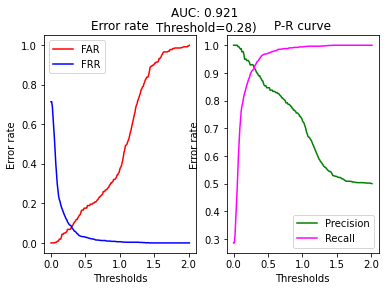

In [7]:
contrastive_utils.draw_eval_contrastive(siamese_network2, X, Y)

## Triplets

In [8]:
# defining the embedding and network
embedding = triplet_utils.embedding_net(embeddingsize, INPUT_SHAPE)
siamese_network3 = triplet_utils.build_triplet_model(INPUT_SHAPE, embedding, margin=1)
siamese_network3.compile(loss=None, optimizer=optimizer)

siamese_network3.summary()

siamese_network3.load_weights('../input/signature-verification-weights/CEDAR_3x_2.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_network (Sequential) (None, 10)           411685322   anchor_input[0][0]               
                                                                 positive_input[0][0]       

In [9]:
network = tf.keras.Model(siamese_network3.layers[-2].input,
                         siamese_network3.layers[-2].output)
network.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 224, 224, 128)     6400      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 128)     409728    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 64)        204864    
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0   

TRIPLETS PROBS: 100%|██████████| 2309/2309 [24:17<00:00,  1.58it/s]


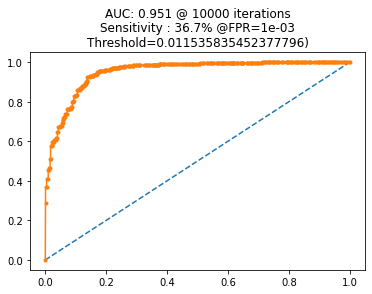

In [10]:
triplet_utils.draw_eval_triplets(network, 10000, X, Y)

## Quadruplets

In [14]:
# defining the embedding and network
embedding = quadruplet_utils.embedding_net(embeddingsize, INPUT_SHAPE)
metric_network = quadruplet_utils.build_metric_network(single_embedding_shape=[embeddingsize])
siamese_network4 = quadruplet_utils.build_quadruplet_model(
    INPUT_SHAPE, embedding, metric_network, margin=1, margin2=0.5
)
siamese_network4.compile(loss=None, optimizer=optimizer)

siamese_network4.summary()

siamese_network4.load_weights('../input/signature-verification-weights/CEDAR_4x_2.h5')

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
negative2_input (InputLayer)    [(None, 224, 224, 1) 0                                            
____________________________________________________________________________________________

In [17]:
network = tf.keras.Model(siamese_network4.layers[-6].input,
                         siamese_network4.layers[-6].output)
network.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20_input (InputLayer) [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 224, 224, 128)     6400      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 128)     409728    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 56, 56, 64)        204864    
_________________________________________________________________
flatten_6 (Flatten)          (None, 200704)            0   

QUADRUPLETS PROBS: 100%|██████████| 2309/2309 [24:13<00:00,  1.59it/s]


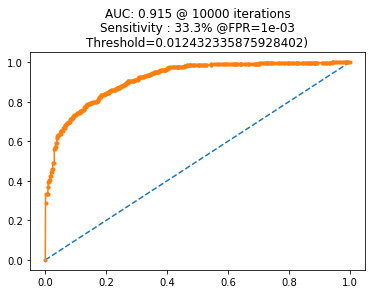

In [18]:
quadruplet_utils.draw_eval_quadruplets(network, 10000, X, Y)